In [1]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation

# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [3]:
# append in ONE data
data=train.append(test, ignore_index=True)

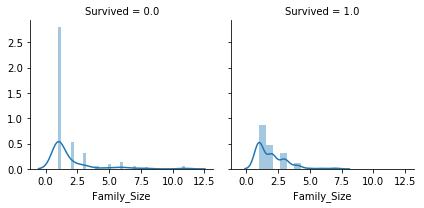

In [4]:
data['Family_Size']=data['Parch']+data['SibSp']+1
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [5]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
data['Title1'].head(10)
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
data['Title1'].head(10)
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [7]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [ ]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})

In [ ]:
tt['PassengerId'].describe()

In [ ]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<14]='None' #STONO是14
tt

In [ ]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

In [8]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
#data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

In [ ]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [9]:
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

In [10]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [11]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1
data['Quotation_ind']= data['Name'].str.contains('\"',na=False)*1
qta = data.groupby(by='Quotation_ind', as_index=False).agg({'PassengerId': pd.Series.nunique})
qta.head()

,Quotation_ind,PassengerId
0,0,1234
1,1,75


In [12]:
deplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(data.loc[data.Ticket == tk,['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Ticket_info_rev', 'Cabin_info',
       'NickName_ind', 'Quotation_ind']])
deplicate_ticket = pd.concat(deplicate_ticket)
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_Size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_Size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size > 1]))
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, df_grp in data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,Mr,Mr,X,NaN,E,0,0
20,35.0,NaN,S,26.0000,"Fynney, Mr. Joseph J",0,21,2,male,0,0.0,239865,1,Mr,Mr,X,NaN,NaN,0,0
791,16.0,NaN,S,26.0000,"Gaskell, Mr. Alfred",0,792,2,male,0,0.0,239865,1,Mr,Mr,X,NaN,NaN,0,0
195,58.0,B80,C,146.5208,"Lurette, Miss. Elise",0,196,1,female,0,1.0,PC 17569,1,Miss,Miss,PC,NaN,B,0,0
681,27.0,D49,C,76.7292,"Hassab, Mr. Hammad",0,682,1,male,0,1.0,PC 17572,1,Mr,Mr,PC,NaN,D,0,0
61,38.0,B28,S,80.0000,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1,Miss,Miss,X,NaN,B,0,0
829,62.0,B28,S,80.0000,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1,Mrs,Mrs,X,NaN,B,1,0


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,NaN,C,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,NaN,C,1,0
137,37.0,C123,S,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,2,Mr,Mr,X,NaN,C,0,0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,Master,Master,X,NaN,NaN,0,0
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,5,Miss,Miss,X,NaN,NaN,0,0
374,3.0,NaN,S,21.0750,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,5,Miss,Miss,X,NaN,NaN,0,0
567,29.0,NaN,S,21.0750,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,5,Mrs,Mrs,X,NaN,NaN,1,0


people keep the same ticket: 596 
friends: 127 
families: 469 
people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [ ]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

In [ ]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

In [13]:
data_dummies.columns

NameError: name 'data_dummies' is not defined

In [14]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Cabin_info', 'NickName_ind', 'Quotation_ind',
       'Connected_Survival'],
      dtype='object')

In [26]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns
dataTrain = dataTrain[['Age', 'Cabin', 'Embarked', 'Fare', 'Parch',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size',
       'Title2', 'Ticket_info', 'Cabin_info', 'NickName_ind', 'Quotation_ind',
       'Connected_Survival']]
dataTest = dataTest[['Age', 'Cabin', 'Embarked', 'Fare', 'Parch',
       'Pclass', 'Sex', 'SibSp', 'Ticket', 'Family_Size',
       'Title2', 'Ticket_info', 'Cabin_info', 'NickName_ind', 'Quotation_ind',
       'Connected_Survival']]

In [ ]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

In [ ]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'Pclass','Survived', 'SibSp','Quotation_ind', 'Connected_Survival',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO'
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
dataTest = dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp','Quotation_ind', 'Connected_Survival',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO',
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]

In [27]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [28]:
# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTrain)
X = dataTrain.drop('Survived', axis=1)
y = dataTrain.Survived

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [29]:
#bayesian-optimization
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [30]:
#Step 2: Set the range for each parameter (make the range as narrow as possible)
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (40, 50),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

In [31]:
# ### Put all together
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=7, n_estimators=10000, learning_rate=0.04, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, max_bin):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin'] = int(round(max_bin))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 40),
                                            'feature_fraction': (0.01, 0.9),
                                            'bagging_fraction': (0.1, 0.9),
                                            'max_depth': (3, 7),
                                            'lambda_l1': (0.2, 2),
                                            'lambda_l2': (0.02, 0.09),
                                            'min_split_gain': (0.03, 0.08),
                                            'min_child_weight': (3, 12),
                                           'max_bin': (5,15)}, random_state=7)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [22]:
opt_params = bayes_parameter_opt_lgb(X, y)
print(opt_params)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.895307 + 0.0243199
    1 | 00m01s |    0.89640 |             0.2639 |             0.8195 |      1.9198 |      0.0540 |    7.2408 |      5.8773 |             9.5535 |           0.0700 |      12.2892 | 
[200]	cv_agg's auc: 0.890025 + 0.0226075
[400]	cv_agg's auc: 0.892209 + 0.0216073
[600]	cv_agg's auc: 0.893206 + 0.0204701
    2 | 00m02s |    0.89331 |             0.4926 |             0.1999 |      1.4292 |      0.0296 |   10.7486 |      4.6520 |            10.3910 |           0.0770 |      33.3976 | 
[200]	cv_agg's auc: 0.893992 + 0.021188
[400]	cv_agg's auc: 0.895639 + 0.019558
    3 | 00m02s

[200]	cv_agg's auc: 0.894193 + 0.0237657
   29 | 00m25s |    0.89570 |             0.3514 |             0.8825 |      1.9534 |      0.0784 |    9.0770 |      3.0650 |             7.7085 |           0.0367 |      10.0228 | 
[200]	cv_agg's auc: 0.893044 + 0.0194639
[400]	cv_agg's auc: 0.894785 + 0.0175583
   30 | 00m25s |    0.89567 |             0.7021 |             0.1995 |      0.2799 |      0.0691 |   14.3793 |      3.3965 |             3.0748 |           0.0597 |      39.9456 | 
[200]	cv_agg's auc: 0.896725 + 0.0239642
[400]	cv_agg's auc: 0.897378 + 0.0211121
   31 | 00m24s |    0.89836 |             0.1752 |             0.8697 |      0.2238 |      0.0705 |   14.5070 |      3.6690 |             8.3056 |           0.0539 |      39.3662 | 
[200]	cv_agg's auc: 0.891319 + 0.023445
[400]	cv_agg's auc: 0.894504 + 0.0189531
   32 | 00m26s |    0.89495 |             0.1406 |             0.2371 |      0.2223 |      0.0455 |   14.9617 |      4.7617 |            11.6350 |           0.0450 |   

In [23]:
# LGBM with Bayesian Optimization
LGBM_bayes = LGBMClassifier(
    num_leaves= int(opt_params['num_leaves']),
    feature_fraction = opt_params['feature_fraction'],
    bagging_fraction = opt_params['bagging_fraction'],
    max_depth= int(opt_params['max_depth']),
    lambda_l1 = opt_params['lambda_l1'],
    lambda_l2 = opt_params['lambda_l2'],
    min_split_gain= int(opt_params['min_split_gain']),
    min_child_weight= int(opt_params['min_child_weight']),
    max_bin = int(opt_params['max_bin']),
    random_state=7, 
    n_estimators=1000, 
    learning_rate=0.05,
    application = 'binary',
    num_iterations = 10000, 
    early_stopping_round = 100, 
    metric = 'auc'
  )



LGBM_bayes_fit = LGBM_bayes.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.942112	valid_1's auc: 0.860892
Early stopping, best iteration is:
[84]	training's auc: 0.939667	valid_1's auc: 0.862952


Accuracy:0.802
Classification report
             precision    recall  f1-score   support

        0.0       0.78      0.91      0.84       156
        1.0       0.84      0.65      0.73       112

avg / total       0.81      0.80      0.80       268

Confusion matrix
[[142  14]
 [ 39  73]]
ROC AUC Score
0.862952152014652
Feature importances: [79, 33, 23, 79, 57, 6, 35, 44, 6, 105, 9, 14, 29, 23, 10, 22, 0, 67]
Plot feature importances...


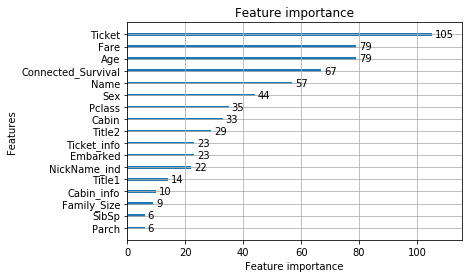

In [24]:
# measure performance
LGBM_bayes_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_bayes, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True)

# feature importances
print('Feature importances:', list(LGBM_bayes.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_bayes_fit, max_num_features=25)
plt.show()

In [25]:
#predict Test data
#submit the data to kaggle
LGBM_bayes_fit_res =LGBM_bayes_fit.predict(dataTest)
submit['Survived'] = LGBM_bayes_fit_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Cabin, Embarked, Name, Sex, Ticket, Title1, Title2, Ticket_info, Cabin_info

In [ ]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

In [ ]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")

#### Important Features Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp